# Matrix factorization

En esta clase trabajaremos con un dataset que contiene reviews de películas.

El objetivo será recomendar películas nuevas a los usuarios (el usuario no debe haberla visto anteriormente).

El principal objetivo de este notebook es aprender a utilizar algunas herramientas y métodos para construir sistemas de recomendación. Trabajaremos con un set de datos muy chico por lo que los resultados que obtendremos no serán muy buenos. Luego trabajaremos con datasets más reales (y grandes) con los cuales podremos obtener resultados mucho más llamativos.

In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
# !unzip /content/ml-latest.zip -d ./

In [2]:
import pandas as pd
import numpy as np

En el primer dataset tenemos los nombres de las películas con su género.

In [3]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


En el siguiente, tenemos lo que más nos interesa para un filtro colaborativo: Las interacciones entre usuarios y películas

In [4]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
ratings.shape

(33832162, 4)

In [6]:
ratings.userId.nunique()

330975

<style>
pr { color: Peru }
s { color: Salmon }
o { color: Orange }
y { color: Yellow }
</style>
Tenemos 610 usuarios <pr>330975</pr>

Podemos ver que tenemos una columna timestamp. Este tipo de datos se puede convertir a una fecha de la siguiente manera:

In [7]:
from datetime import datetime
ts = int('1225734739')

print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2008-11-03 17:52:19


O tomando solamente la fecha (sin horario):

In [8]:
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))

2008-11-03


Convertir los timestamps a fecha (sin hora):

<style>
pr { color: Peru }
s { color: Salmon }
o { color: Orange }
y { color: Yellow }
</style>
Las siguientes celdas cambian el tipo de dato de la columna timestamp para que sea más simple trabajar con fechas  
<pr>Se cambia el tipo datos de "timestamp" a date</pr>

In [9]:
ratings["timestamp"] = pd.to_datetime(ratings['timestamp'], unit='s')

In [10]:
ratings.head()
print(ratings.timestamp.dtypes)

datetime64[ns]


In [11]:
import pandas as pd

# Crear un DataFrame de ejemplo
data = {'year': ['1995', '1996', '1997', '1998', '1999']}
dff = pd.DataFrame(data)

# Convertir la columna 'year' a tipo de datos datetime
dff['year'] = pd.to_datetime(dff['year'], format='%Y')

# Verificar el resultado
print(dff.dtypes)
print(dff)

year    datetime64[ns]
dtype: object
        year
0 1995-01-01
1 1996-01-01
2 1997-01-01
3 1998-01-01
4 1999-01-01


<style>
pr { color: Peru }
s { color: Salmon }
o { color: Orange }
y { color: Yellow }
</style>
<pr>Se crea un df nuevo con una columna con el año del review</pr>

In [12]:
plot_df = ratings.copy()
plot_df['year'] = ratings['timestamp'].dt.year

In [13]:
plot_df.head()

,userId,movieId,rating,timestamp,year
0,1,1,4.0,2008-11-03 17:52:19,2008
1,1,110,4.0,2008-11-05 06:04:46,2008
2,1,158,4.0,2008-11-03 17:31:43,2008
3,1,260,4.5,2008-11-03 18:00:04,2008
4,1,356,5.0,2008-11-03 17:58:39,2008


¿En qué intervalo de fechas tenemos reviews? (fecha minima y maxima)

<style>
pr { color: Peru }
s { color: Salmon }
o { color: Orange }
y { color: Yellow }
</style>
<pr>Se obtiene el rango de fechas.</pr>

In [14]:
#COMPLETAR (min)#COMPLETAR (max)
fecha_minima = ratings['timestamp'].min()
fecha_maxima = ratings['timestamp'].max()

print("Fecha mínima:", fecha_minima)
print("Fecha máxima:", fecha_maxima)

Fecha mínima: 1995-01-09 11:46:44
Fecha máxima: 2023-07-20 08:53:33


In [15]:
fecha_minima = plot_df['year'].min()
fecha_maxima = plot_df['year'].max()

print("Fecha mínima:", fecha_minima)
print("Fecha máxima:", fecha_maxima)

Fecha mínima: 1995
Fecha máxima: 2023


Ploteamos la cantidad de reviews por año:

In [16]:
# plot_df = ratings.copy()
# plot_df["year"] = ratings.timestamp.dt.year
# plot_df = plot_df.groupby("year", as_index=False).count()[["year", "userId"]]
# plot_df.columns = ["year", "reviews_count"]
# plot_df.head()

In [17]:
# Contar las calificaciones por año
reviews_por_año = plot_df['year'].value_counts().sort_index()

In [18]:
display(reviews_por_año.head())

year
1995          4
1996    1732721
1997     763613
1998     329419
1999    1230159
Name: count, dtype: int64

In [19]:
type(reviews_por_año)

pandas.core.series.Series

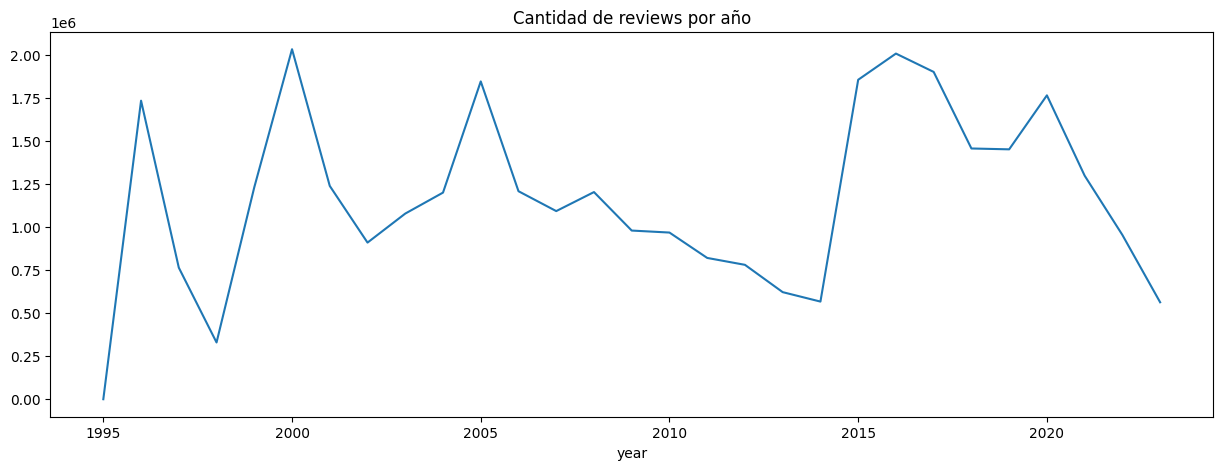

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.lineplot(x=reviews_por_año.index, y=reviews_por_año.values)
plt.title("Cantidad de reviews por año")
plt.show()

Ahora vamos a dividir el dataset en train y test.

En este caso, tenemos datos desde 1996 hasta 2018, pero no utilizaremos todos estos años.

Vamos a entrenar nuestro modelo con todas las interacciones que ocurrieron entre el 1ro de enero de 2017 y el 1ro de enero de 2018. En base a esto buscaremos predecir las películas que los usuarios van a ver en el resto de 2018.

Para comparar la columna timestamp contra una fecha, pueden utilizar el siguiente objeto: `datetime(year=..., month=..., day=...)`

Por ejemplo: `datetime(year=2015, month=10, day=1)`

Dividir el set de interacciones en train y test.

In [21]:
train = plot_df[(plot_df['timestamp'] >= '2017-01-01') & (plot_df['timestamp'] <= '2018-01-01')]
train.head()

,userId,movieId,rating,timestamp,year
1140,16,57183,4.5,2017-04-05 00:55:42,2017
1143,16,115617,4.0,2017-04-05 00:53:43,2017
1145,16,136016,4.5,2017-04-05 00:48:04,2017
1948,23,527,5.0,2017-12-26 00:51:00,2017
1949,23,2959,4.5,2017-12-26 00:53:43,2017


In [22]:
train.shape

(1899523, 5)

In [23]:
train.userId.nunique()

19420

In [24]:
test = plot_df[(plot_df['timestamp'] >= '2018-01-02') & (plot_df['timestamp'] <= '2018-12-31')]
test.head()

,userId,movieId,rating,timestamp,year
153,3,296,5.0,2018-09-05 18:58:28,2018
154,3,318,5.0,2018-09-05 18:57:23,2018
155,3,858,5.0,2018-09-05 18:57:29,2018
156,3,2959,5.0,2018-09-05 18:57:20,2018
157,3,3114,5.0,2018-09-05 19:04:25,2018


In [25]:
test.shape

(1441315, 5)

In [26]:
test.userId.nunique()

17346

Podemos tener un problema...

¿Qué pasa si tenemos un usuario que aparece en test pero no en train? ¿Qué le recomendamos?

COLD START...

Vamos a ver si tenemos este problema. Buscar usuarios que estén en el set de test y NO estén en el de train (máscaras..)

In [27]:
#COMPLETAR
test_userIds = set(test['userId'])
train_userIds = set(train['userId'])
userIds_not_in_train = test_userIds - train_userIds
# display(userIds_not_in_train)
display(len(userIds_not_in_train))

12327

In [28]:
#COMPLETAR
test_movieIds = set(test['movieId'])
train_movieIds = set(train['movieId'])
movieIds_not_in_train = test_movieIds - train_movieIds
# display(movieIds_not_in_train)
display(len(movieIds_not_in_train))

10645

<style>
pr { color: Peru }
s { color: Salmon }
o { color: Orange }
y { color: Yellow }
</style>
<pr>El otro problema es que tambien puede no haber moviesId que recomendar.   
Basicamente el conjunto de entrenamiento (train) debe contener al menos todos los userId y todas las películas (movieId) que aparecen en el conjunto de prueba (test).</pr>

Ahora que tenemos los sets divididos en train y test, vamos a armar la matriz de interacciones.

Para esto necesitamos únicamente 3 columnas de las 4 que tiene el dataset de interacciones. ¿Cuáles son?


In [29]:
# Obtener userIds y movieIds de train + test
userIds = np.union1d(train['userId'].unique(), test['userId'].unique())
movieIds = np.union1d(train['movieId'].unique(), test['movieId'].unique())
# display(len(userIds))
# display(len(movieIds))

# Crear la matriz con las interacciones
train_pivot=train.pivot(index='userId', columns='movieId', values='rating')

# Reemplazar con ceros los NaNs
interactions_matrix=train_pivot.fillna(0)

In [30]:
interactions_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,183135,183139,183141,183145,183149,183153,183155,183157,183159,183161
userId,,,,,,,,,,,,,,,,,,,,,
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
from scipy.sparse import csr_matrix

# Crear una matriz dispersa csr con los valores distintos de cero
reduced_matrix = csr_matrix(interactions_matrix)

# Imprimir la nueva matriz reducida
print(reduced_matrix)

  (0, 10503)	4.5
  (0, 17688)	4.0
  (0, 21446)	4.5
  (1, 484)	5.0
  (1, 2515)	4.5
  (1, 4287)	5.0
  (1, 12705)	5.0
  (1, 14563)	3.5
  (1, 16549)	4.5
  (1, 16874)	5.0
  (1, 18338)	4.0
  (2, 38)	2.5
  (2, 102)	2.5
  (2, 237)	1.0
  (2, 243)	1.0
  (2, 289)	3.5
  (2, 325)	5.0
  (2, 439)	0.5
  (2, 466)	2.0
  (2, 484)	1.0
  (2, 539)	0.5
  (2, 543)	4.0
  (2, 1000)	1.5
  (2, 1002)	1.0
  (2, 1047)	3.0
  :	:
  (19419, 13604)	4.0
  (19419, 13771)	3.5
  (19419, 13777)	4.5
  (19419, 14029)	4.0
  (19419, 14418)	4.0
  (19419, 14430)	5.0
  (19419, 14451)	4.5
  (19419, 14864)	4.0
  (19419, 14922)	4.5
  (19419, 14942)	1.5
  (19419, 15280)	2.0
  (19419, 15320)	2.0
  (19419, 15937)	2.5
  (19419, 16038)	5.0
  (19419, 16519)	5.0
  (19419, 16541)	5.0
  (19419, 17167)	4.0
  (19419, 17186)	5.0
  (19419, 18259)	5.0
  (19419, 18953)	5.0
  (19419, 18961)	4.0
  (19419, 24176)	3.5
  (19419, 24841)	4.5
  (19419, 27466)	4.0
  (19419, 28094)	5.0


En este caso ¿tenemos ratings implícitos o explícitos?

In [32]:
# interactions = train[matrix_columns]
# interactions.head()

Para armar la matriz utilizaremos una pivot table de pandas.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html

Veamos el ejemplo de la documentación:

In [33]:
# df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
#                            'two'],
#                    'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
#                    'baz': [1, 2, 3, 4, 5, 6],
#                    'zoo': ['x', 'y', 'z', 'q', 'w', 't']})

# df.head()

In [34]:
# df.pivot(index='foo', columns='bar', values='baz')

Basándose en el ejemplo anterior, armar la matriz de interacciones (solo para train).

In [35]:
# interactions_matrix = #COMPLETAR

In [36]:
# interactions_matrix.head()

Van a ver una matriz con muchos NaN.

¿Qué significan los NaN?

Completar los NaN con 0.

In [37]:
#COMPLETAR

In [38]:
# interactions_matrix.head()

¿Cuántas filas y columnas tiene?

In [39]:
# interactions_matrix.shape

En este caso, al ser un dataset chico no tenemos muchos usuarios y películas. La matriz es relativamente chica.

En general (con datasets que trabajaremos en la entrega por ejemplo) vamos a obtener matrices muy grandes y dispersas (sparse).

Por esta razón, vamos a transformar la matriz a csr matrix (compressed sparse row): https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



In [40]:
# from scipy.sparse import csr_matrix

In [41]:
# interactions_matrix_csr = csr_matrix(interactions_matrix.values)

In [42]:
# interactions_matrix_csr

La siguiente celda generará un diccionario que nos servirá como índice más adelante.

Tiene como keys el id de cada usuario y como valor el indice (número de fila en la matriz)

In [43]:
# user_ids = list(interactions_matrix.index)
# user_dict = {}
# counter = 0 
# for i in user_ids:
#     user_dict[i] = counter
#     counter += 1

In [44]:
# user_dict

# Modelo

Ya tenemos la matriz lista para entrenar el modelo.

Utilizaremos la librería LFM (light fm). https://making.lyst.com/lightfm/docs/home.html

Existen otras librerías como "surprise" (muy lenta).

Además microsoft publicó este año un repositorio que implementa muchos sistemas de recomendación y es muy bueno para tener en cuenta: https://github.com/microsoft/recommenders

Primero que nada instalamos la librería y definimos nuestro modelo:



In [49]:
# %pip install cython numpy
# SET "CFLAGS=-fopenmp" & SET "LDFLAGS=-fopenmp" & python setup.py install
# %pip install lightfm

In [45]:
from lightfm import LightFM

model = LightFM(no_components=3, random_state=100, learning_rate=0.03)

c:\Users\admin\Desktop\Icaro\Codigo\Resumen\.venv\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Ahora model tiene el método .fit igual que todas las librerías que vimos hasta ahora.

Entrenar el modelo con la matriz csr por 10 epochs:

In [ ]:
%%time
model = #COMPLETAR

CPU times: user 25.9 ms, sys: 0 ns, total: 25.9 ms
Wall time: 26.7 ms


Ahora podríamos generar recomendaciones simplemente haciendo:

In [ ]:
import numpy as np
user_x = user_dict[18]
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)
#ACA GENERAMOS PREDICCIONES
preds = model.predict(user_ids=user_x, item_ids = item_ids)

In [ ]:
preds

array([1.3790532 , 1.1839919 , 0.979228  , ..., 1.1710345 , 1.0493778 ,
       0.99154365], dtype=float32)

Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 18. Podemos ordenarlo y obtener las mejores recomendaciones

In [ ]:
scores = pd.Series(preds)
scores.index = interactions_matrix.columns
recomms_18 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10

Recomendaciones para el usuario 18:

In [ ]:
recomms_18

[318, 356, 2959, 79132, 2571, 296, 122904, 260, 60069, 168252]

Al ser un dataset muy chico, lo más probable es que terminemos recomendando contenidos populares a todos los usuarios.

Como dijimos anteriormente, el objetivo es que comprendamos como utilizar las herramientas con un dataset simple para luego aplicarlo a un dataset más real.

¿Qué había visto el usuario 18 (en el set de train)?

In [5]:
#COMPLETAR

Ya había visto alguno de los contenidos que le estamos recomendando?

In [ ]:
train[(train.userId==18) & (train.movieId.isin(recomms_18))].movieId.unique()

array([168252])

El usuario ya había visto la película 168252.

Deberíamos filtrarla de las recomendaciones ya que no queremos recomendar contenido visto anteriormente.

Para esto:

1) Obtener listado de películas vistas (en train) por el usuario 18

In [ ]:
user_18_watched = #COMPLETAR

2) Filtrar esas películas de la lista de recomendaciones

In [ ]:
recomms_18 = [rec for rec in recomms_18 if rec not in user_18_watched]

In [ ]:
recomms_18

[318, 356, 2959, 79132, 2571, 296, 122904, 260, 60069]

En un sistema de filtro colaborativo siempre puede pasar que el modelo nos recomiende algún item que el usuario ya vió. También puede pasar que nos recomiende algún item que no queremos recomendar por alguna razon. Puede ser alguna restricción del negocio, un contenido que no estará disponible más adelante, etc.

Por todo esto, es importante siempre pedirle al modelo que nos genere más recomendaciones de las que queremos mostrarle al usuario. Por ejemplo, si a nuestros usuarios queremos mostrarles 10 recomendaciones, al sistema le podríamos pedir que nos recomiende 50. Luego, sobre estas 50 recomms aplicamos filtros (contenidos ya vistos, contenidos que no queremos recomendar, etc) y podrían quedarnos por ejemplo unas 30 recomendaciones. De estas 30 tomamos las mejores 10 y nos aseguramos de que siempre le vamos a estar recomendando 10 items al usuario.

Si nosotros le pedimos al modelo únicamente 10 recomendaciones, luego de aplicar los filtros nos pueden quedar pocas (o ninguna) recomm.



**COLD START**

¿Qué pasa con los usuarios que no tenemos en el set de train?

Podemos recomendarles por ejemplo, los contenidos más populares.

Para esto, basandonos en el set de train vamos a generar un dataset ordenado por popularidad.

Generar un dataset ordenado por popularidad (cantidad de usuarios que le dieron un rating, sin importar el rating).

In [ ]:
popularity_df = #COMPLETAR

popularity_df.columns=["movieId", "popularity"]
popularity_df.head()

,movieId,popularity
112,318,31
130,356,28
2458,79132,25
791,2571,22
894,2959,22


Obtener una lista con los 10 contenidos más populares

In [ ]:
popular_content = #COMPLETAR

In [7]:
popular_content

Ahora basándonos en el ejemplo anterior, vamos a generar 10 recomendaciones para todos los usuarios. 

Debemos tener en cuenta:

- Filtrar contenidos que el usuario vio anteriormente
- Si el usuario no está en el set de train, recomendarle los 10 contenidos más populares


In [ ]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(test.userId.unique()):
    
    #-----------
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if #COMPLETAR:
    #-----------

      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      #---------------
      # Generar las predicciones para el usuario x
      preds = #COMPLETAR
      #--------------

      #--------------
      # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      # 
      # COMPLETAR
      #
      #
      #--------------

      #--------------
      # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = # COMPLETAR
      #---------------------

      #---------------------
      # Filtrar contenidos ya vistos y quedarse con los primeros 10
      recomms = #COMPLETAR
      #--------------------

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(scores)
    
    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(popular_content)




Ya tenemos las recomendaciones. Convertimos el dict a dataframe:

In [ ]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms
0,18,"[318, 356, 2959, 79132, 2571, 296, 122904, 260..."
1,25,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
2,50,"[318, 356, 79132, 2571, 2959, 122904, 60069, 1..."
3,62,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
4,68,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
5,77,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
6,89,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
7,98,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
8,103,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
9,105,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."


Vemos que nuestro sistema no es muy bueno ya que a todos les recomienda en primer lugar el contenido 318 (el más popular). Además, a la mayoría de los usuarios les estamos dando reocmendaciones de cold start ya que el dataset es pequeño.

Este notebook les servirá como una buena guía para implementar sistemas de recomendación con otros datasets (por ejemplo, el de la entrega de este sprint).

Tengan en cuenta:

- No siempre los ratings van a estar explícitos como en este caso. Si no estuviesen explícitos, tienen muchas opciones para completar la matriz. Pueden simplemente completarla con 1s y 0s (indicando si el usuario vió o no vió el contenido). Si están trabajando con productos, pueden utilizar la cantidad de veces que el usuario compró el producto. Todo lo que se les ocurra para obtener una medida de que tan fuerte es la relación entre usuario-item es válido.

- Siempre recuerden filtrar recomendaciones que no les interesa generar. Recuerden que en un sistema de recomendación siempre vamos a tener una cantidad de espacio limitada para mostrar recomendaciones. Si tenemos por ejemplo solo 3 lugares, las 3 recomendaciones que hagamos deben ser muy buenas para que el sistema funcione. Si de 3 recomendaciones, le mostramos al usuario 2 películas que ya vió, nuestro sistema no tendrá sentido.
De la misma forma si le recomendamos por ejemplo películas que estaban disponibles en nuestro sistema al momentro de entrenar el modelo, pero al momento de mostrar la recomendación ya no están, tampoco tiene sentido.
